In [1]:
import contextlib
from datetime import datetime
from fastai import *
from fastai.tabular import *
import io
import pandas as pd
from pathlib import Path
import random

In [2]:
DATA_PATH = Path('../../data/interim')
path = Path('../../models/')

In [3]:
# Import train_valid_data and test_data dataframes
train_valid_df_raw = pd.read_csv(DATA_PATH/'train_valid_data.csv', low_memory=False)
train_valid_df = train_valid_df_raw.copy()

# Sort by date since we'll want to split by date for train/validation sets
train_valid_df.sort_values('date')

# Drop week_start and day_of_week as they'll get taken into account by add_datepart() for date
train_valid_df.drop('week_start', axis='columns', inplace=True)
train_valid_df.drop('day_of_week', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we don't need to forecast those
train_valid_df = train_valid_df[train_valid_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(train_valid_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year']

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
procs = [FillMissing, Categorify, Normalize]

df = train_valid_df

# Validation set is just 80% of the whole thing
valid_idx = range(int(0.8 * len(df)), len(df))
dep_var = 'sales'

# List out the features that we don't know for predictions
unknown_in_future = ['cloud_cover', 'customers', 'dew_point_c', 'events', 'max_gust_speed_km_h', 'max_humidity',
                     'max_sea_level_pressureh_pa', 'max_temperature_c', 'max_visibility_km', 'max_wind_speed_km_h',
                     'mean_dew_point_c', 'mean_humidity', 'mean_sea_level_pressureh_pa', 'mean_temperature_c', 
                     'mean_visibility_km', 'mean_wind_speed_km_h', 'min_dew_point_c',  'min_humidity',
                     'min_sea_level_pressureh_pa', 'min_temperature_c', 'min_visibility_km', 'precipitationmm', 'trend',
                     'wind_dir_degrees']

# List of features that we know for predictions
known_in_future = set(train_valid_df.columns) - set(unknown_in_future) - set('sales')

print('Known: ', sorted(known_in_future), '\n')

# Make sure that features we don't know for predictions are all marked as NA in the validation set
# Our FillMissing pre-processing will account for these
# The test set already has these marked as NA
train_valid_df.loc[valid_idx[0]:valid_idx[-1], unknown_in_future] = np.NaN

data = (TabularList.from_df(df, path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
                   .split_by_idx(valid_idx)
                   .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                   .databunch())

data.show_batch()

Known:  ['Day', 'Dayofweek', 'Dayofyear', 'Elapsed', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start', 'Month', 'Week', 'Year', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'open', 'promo', 'promo2', 'promo2_since_week', 'promo2_since_year', 'promo_interval', 'sales', 'school_holiday', 'state', 'state_holiday', 'store', 'store_type'] 



assortment,events,promo_interval,state,state_holiday,store_type,Day,Dayofweek,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Month,Week,Year,min_dew_point_c_na,max_visibility_km_na,min_sea_level_pressureh_pa_na,min_temperature_c_na,mean_visibility_km_na,min_humidity_na,trend_na,mean_dew_point_c_na,max_humidity_na,max_wind_speed_km_h_na,max_temperature_c_na,cloud_cover_na,mean_wind_speed_km_h_na,dew_point_c_na,wind_dir_degrees_na,max_gust_speed_km_h_na,mean_sea_level_pressureh_pa_na,min_visibility_km_na,mean_humidity_na,max_sea_level_pressureh_pa_na,customers_na,mean_temperature_c_na,precipitationmm_na,min_dew_point_c,max_visibility_km,competition_open_since_month,min_sea_level_pressureh_pa,min_temperature_c,mean_visibility_km,min_humidity,sales,trend,mean_dew_point_c,max_humidity,max_wind_speed_km_h,max_temperature_c,Elapsed,cloud_cover,store,mean_wind_speed_km_h,promo2_since_week,dew_point_c,wind_dir_degrees,school_holiday,max_gust_speed_km_h,competition_open_since_year,competition_distance,mean_sea_level_pressureh_pa,min_visibility_km,mean_humidity,max_sea_level_pressureh_pa,promo2,customers,open,Dayofyear,mean_temperature_c,promo2_since_year,promo,precipitationmm,target
a,No Events,None,HE,0,a,4,3,False,False,False,False,False,False,4,14,2013,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-1.6966,-1.0479,0.0054,-0.5101,-0.8601,-0.0588,-1.2168,-1.1370,-0.5219,-1.8086,-3.1872,1.0517,-0.5313,-1.3176,1.0362,-0.8591,0.6481,-0.0432,-1.8186,-1.5427,2.0899,0.0091,-0.0321,-0.3599,-0.6759,0.6076,-1.8596,-0.6306,-0.9677,-1.1538,0.0000,-0.6412,-0.6131,0.0256,-0.8994,-0.3027,8.171882
a,Fog-Rain-Snow,None,NW,0,c,20,2,False,False,False,False,False,False,3,12,2013,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.7683,-1.9436,0.0054,-1.4822,-1.2094,-2.1863,2.4748,-0.2582,-0.5219,-0.8807,0.9584,-0.3066,-1.6016,-1.3759,1.0362,1.2350,-0.2577,-0.0432,-1.0945,-1.9752,-0.4785,0.0091,-0.0321,-0.6371,-1.4490,-1.7442,1.7806,-0.7648,-0.9677,0.1774,0.0000,-0.7849,-1.3932,0.0256,1.1118,2.9880,8.744806
a,No Events,None,BE,0,a,22,3,False,False,False,False,False,False,5,21,2014,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,1.0885,0.6155,1.8303,-0.6316,2.1091,3.4870,-1.7280,-0.7124,0.4222,1.1606,-3.4635,0.3108,2.0108,0.2888,0.0391,-0.8684,0.2858,-0.0432,1.0778,-0.6893,-0.4785,0.0091,0.2338,-0.5133,-0.6759,4.3705,-2.5369,-0.7648,-0.9677,-0.1595,0.0000,-0.1812,2.0391,0.0256,1.1118,-0.3027,8.48941
c,#na#,"Jan,Apr,Jul,Oct",BY,0,a,1,5,False,True,False,False,False,False,3,9,2014,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,-0.0256,0.6155,-0.4626,-0.0241,0.0132,-0.0588,-0.0241,1.9259,-0.1023,0.0471,0.1293,-0.0596,0.0039,-0.0302,0.3479,1.4361,-0.2577,1.6748,-0.0083,0.1757,-0.4785,0.0091,-0.1657,-0.6461,-0.0317,0.1373,0.0875,0.0403,1.0334,-0.1948,0.0000,-0.9670,0.0109,-0.6440,-0.8994,-0.3027,9.479069
c,Rain,"Feb,May,Aug,Nov",NW,0,d,21,3,False,False,False,False,False,False,11,47,2013,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,-0.7683,0.6155,1.4481,-1.8467,-0.5107,0.4140,0.7142,0.1738,0.2124,-1.0663,-0.8380,-0.0596,-1.0665,-0.4191,1.0362,0.2854,1.0104,-1.9906,-1.2755,-1.4725,-0.4785,0.0091,0.6334,-0.5469,-1.7067,0.6076,0.0028,-1.4357,1.0334,-0.2220,0.0000,1.5725,-0.9252,1.1100,1.1118,-0.3027,8.939056


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


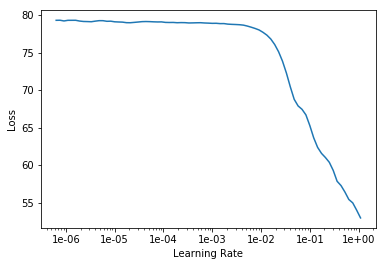

In [4]:
# Consider restricting sales forecasts to within 20% of the maximum seen
# As seen in 'y_range' in the call to tabular_learner below, we don't actually use this -
# in testing, it didn't help, in fact it sat on forecasts too much and hurt our rmspe
max_y = np.max(df.loc[:valid_idx[0], 'sales'])
y_range = torch.tensor([0, np.log(max_y*1.2)], device=defaults.device)

learn = tabular_learner(data, layers=[100,100], ps=[0.001, 0.01], emb_drop=0.01, metrics=exp_rmspe, y_range=None,
                        callback_fns=[partial(callbacks.tracker.TrackerCallback, monitor='exp_rmspe'),
                                      partial(callbacks.tracker.EarlyStoppingCallback, mode='min',
                                              monitor='exp_rmspe', min_delta=0.01, patience=0),
                                      partial(callbacks.tracker.SaveModelCallback, monitor='exp_rmspe', mode='min',
                                              every='improvement',
                                              name=datetime.now().strftime("%Y-%m-%d-%X"))])

learn.lr_find()
learn.recorder.plot()

In [5]:
# Take a look at the model architecture
# The embeddings are for representing each category as a vector
# At the bottom you can see the model is: embedding with dropout and batchnorm, then two hidden layers
# Each hidden layer consists of a linear layer and ReLu, followed by batchnorm and dropout (.001 and .01 respectively)
# Then we have the output layer
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(4, 3)
    (1): Embedding(23, 9)
    (2): Embedding(5, 4)
    (3): Embedding(9, 5)
    (4): Embedding(5, 4)
    (5): Embedding(5, 4)
    (6): Embedding(32, 11)
    (7): Embedding(8, 5)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
    (12): Embedding(3, 3)
    (13): Embedding(3, 3)
    (14): Embedding(13, 7)
    (15): Embedding(53, 15)
    (16): Embedding(4, 3)
    (17): Embedding(3, 3)
    (18): Embedding(3, 3)
    (19): Embedding(3, 3)
    (20): Embedding(3, 3)
    (21): Embedding(3, 3)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
    (24): Embedding(3, 3)
    (25): Embedding(3, 3)
    (26): Embedding(3, 3)
    (27): Embedding(3, 3)
    (28): Embedding(3, 3)
    (29): Embedding(3, 3)
    (30): Embedding(3, 3)
    (31): Embedding(3, 3)
    (32): Embedding(3, 3)
    (33): Embedding(3, 3)
    (34): Embedding(3, 3)
    (35): Embedding(3, 3)
    (36): Embedding(3, 3)
    

In [6]:
# In previous tests I found that although the learning-rate finder above might make you want to use 1e-2 or higher,
# that's too high - it diverges all the time. Instead find the rate that you want to use, then back it 
# down by a factor of ten, so 1e-3 in this case
learn.fit_one_cycle(cyc_len=10, max_lr=1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,0.037244,0.008503,0.081183
2,0.018783,0.002190,0.044622
3,0.013542,0.000816,0.027298


Epoch 4: early stopping


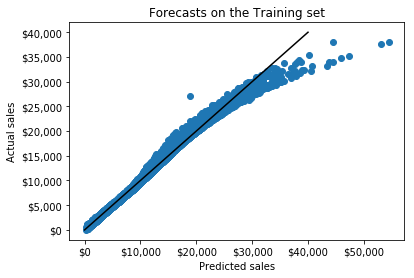

In [7]:
# Our predictions and actuals are in log form, so get them and exp them
train_log_preds, train_log_reals = learn.get_preds(ds_type=DatasetType.Train)
train_preds = np.exp(train_log_preds).flatten()
train_reals = np.exp(train_log_reals)

# Put in dataframe for easy access
train_sub = pd.DataFrame({'Predicted': train_preds, 'Actual': train_reals})

# Prepare and show chart
fig, ax = plt.subplots()
ax.scatter(train_sub.Predicted, train_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')
ax.set_title('Forecasts on the Training set')
ax.set_xlabel('Predicted sales')
ax.set_ylabel('Actual sales')
ax.set_xticklabels(['${:,.0f}'.format(x) for x in ax.get_xticks()])
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()]);

In [8]:
def rmspe(predicted, actual):
    return np.sqrt((((actual - predicted)/actual)**2).sum()/len(actual))

rmspe(train_sub.Predicted.values, train_sub.Actual.values)

0.02770916595880379

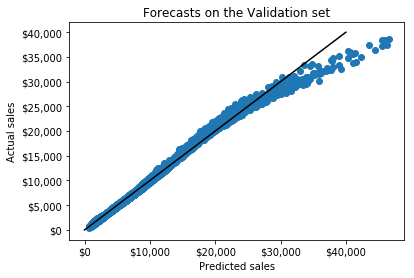

In [9]:
# Our predictions and actuals are in log form, so get them and exp them
log_preds, log_reals = learn.get_preds(ds_type=DatasetType.Valid)
preds = np.exp(log_preds).flatten()
reals = np.exp(log_reals)

# Put in dataframe for easy access
sub = pd.DataFrame({'Predicted': preds, 'Actual': reals})

# Prepare and show chart
fig, ax = plt.subplots()
ax.scatter(sub.Predicted, sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')
ax.set_title('Forecasts on the Validation set')
ax.set_xlabel('Predicted sales')
ax.set_ylabel('Actual sales')
ax.set_xticklabels(['${:,.0f}'.format(x) for x in ax.get_xticks()])
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()]);

In [10]:
rmspe(sub.Predicted.values, sub.Actual.values)

0.029270804244021186

In [11]:
learn.save('current_best')
learn.export('current_best')

In [12]:
# Redoing the training-set transforms for the test set
# Yes this is copy/paste - three strikes and you're out, this is just two

# Import test_data dataframe and prep for use
test_df_raw = pd.read_csv(DATA_PATH/'test_data.csv', low_memory=False)
test_df = test_df_raw.copy()

# Drop week_start and day_of_week as they'll get taken into account by add_datepart() for date
test_df.drop('week_start', axis='columns', inplace=True)
test_df.drop('day_of_week', axis='columns', inplace=True)

# Drop any rows where sales = 0 since we don't need to forecast those
test_df = test_df[test_df.sales != 0]

# Run tabular.add_datepart() on both dfs to add columns about the date: ['Year', 'Month', 'Week', 'Day', 'Dayofweek',
# 'Dayofyear', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
tabular.add_datepart(test_df, 'date', drop=True, time=False)

# Category names, to which we'll apply embeddings
cat_names = ['assortment', 'events', 'promo_interval', 'state', 'state_holiday', 'store_type']

# Add the date-related categories
cat_names += ['Day', 'Dayofweek', 'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end',
              'Is_year_start', 'Month', 'Week', 'Year']

# Continuous-variable names, which we'll make sure are all represented as floats
# Just use set difference to make sure everything is covered
cont_names = list(set(train_valid_df.columns) - set(cat_names))

# Set up transforms to 1) replace missing values for continuous variables by the median column value, 2) transform all
# categorical variables into categories, 3) normalize continuous variables.
procs = [FillMissing, Categorify, Normalize]

In [13]:
# Attach the learner to the test dataframe
# The model was already fit using the test/validation sets, so we'll just get predictions below
learn = load_learner(path='../../models/', fname='current_best',
                      test=TabularList.from_df(test_df, path=path))

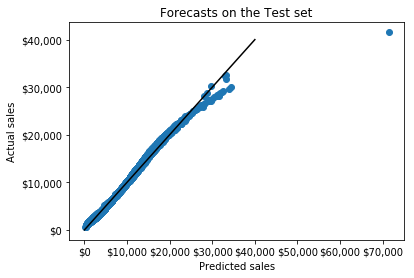

In [14]:
# Our predictions and actuals are in log form, so get them and exp them
log_test_preds, log_test_reals = learn.get_preds(ds_type=DatasetType.Test)
test_preds = np.exp(log_test_preds).flatten()
test_reals = test_df_raw.loc[test_df_raw.sales != 0, 'sales'].values

# Put in dataframe for easy access
test_sub = pd.DataFrame({'Predicted': test_preds, 'Actual': test_reals})

# Prepare and show chart
fig, ax = plt.subplots()
ax.scatter(test_sub.Predicted, test_sub.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')
ax.set_title('Forecasts on the Test set')
ax.set_xlabel('Predicted sales')
ax.set_ylabel('Actual sales')
ax.set_xticklabels(['${:,.0f}'.format(x) for x in ax.get_xticks()])
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()]);

In [15]:
rmspe(test_sub.Predicted.values, test_sub.Actual.values)

0.038976357510878676

In [17]:
# Take a look at predictions off by more than 10% - first, the percent of predictions and total count of predictions
wrongs = test_sub[np.abs((test_sub.Predicted - test_sub.Actual) / test_sub.Actual) > 0.1]

print('Predictions that are wrong by > 10%, as a percent of the total test data set: ',
      '{:.0%}'.format(len(wrongs)/len(test_sub)))
print('Total count of predictions that are wrong by > 10%: ', len(wrongs))
print('Total number of predictions: ', len(test_sub))

Predictions that are wrong by > 10%, as a percent of the total test data set:  2%
Total count of predictions that are wrong by > 10%:  642
Total number of predictions:  40282


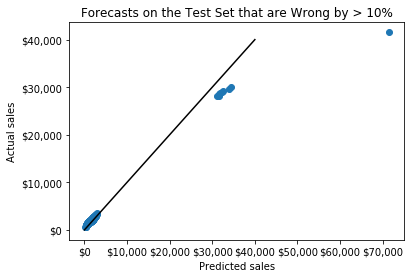

In [18]:
# Create and display the chart of predictions off by more than 10%
fig, ax = plt.subplots()
ax.scatter(wrongs.Predicted, wrongs.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')
ax.set_title('Forecasts on the Test Set that are Wrong by > 10%')
ax.set_xlabel('Predicted sales')
ax.set_ylabel('Actual sales')
ax.set_xticklabels(['${:,.0f}'.format(x) for x in ax.get_xticks()])
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()]);

In [26]:
# Take a look at predictions off by less than 1% - first, the percent of predictions and total count of predictions
close = test_sub[np.abs((test_sub.Predicted - test_sub.Actual) / test_sub.Actual) < 0.01]

print('Predictions that are wrong by < 1%, as a percent of the total test data set: ',
      '{:.0%}'.format(len(close)/len(test_sub)))
print('Total count of predictions that are wrong by < 1%: ', len(close))
print('Total number of predictions: ', len(test_sub))

Predictions that are wrong by < 1%, as a percent of the total test data set:  18%
Total count of predictions that are wrong by < 1%:  7371
Total number of predictions:  40282


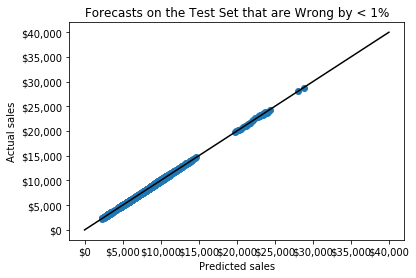

In [27]:
# Create and display the chart of predictions off by less than 1%
fig, ax = plt.subplots()
ax.scatter(close.Predicted, close.Actual)
ax.plot(np.linspace(0,40000,5000), np.linspace(0,40000,5000), color='black')
ax.set_title('Forecasts on the Test Set that are Wrong by < 1%')
ax.set_xlabel('Predicted sales')
ax.set_ylabel('Actual sales')
ax.set_xticklabels(['${:,.0f}'.format(x) for x in ax.get_xticks()])
ax.set_yticklabels(['${:,.0f}'.format(x) for x in ax.get_yticks()]);

In [28]:
# Quick review of some Predicted/Actual pairs
test_sub.head(15)

,Predicted,Actual
0,4198.547852,4097.0
1,9390.799805,9351.0
2,6995.834961,6895.0
3,7734.221680,7656.0
4,6095.762695,6039.0
5,5211.387207,5135.0
6,7674.897461,7604.0
7,4375.139648,4318.0
8,5881.461914,5823.0
9,6228.203125,6125.0
